In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.io import loadmat

In [12]:
def display_data(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        # Display Image
        h = ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')

In [13]:
data = loadmat('../data/ex4data1.mat')
X, y = data['X'], data['y'].ravel()
y[y == 10] = 0 # on places where class is 10, replace with 0
m = y.size # number of training examples

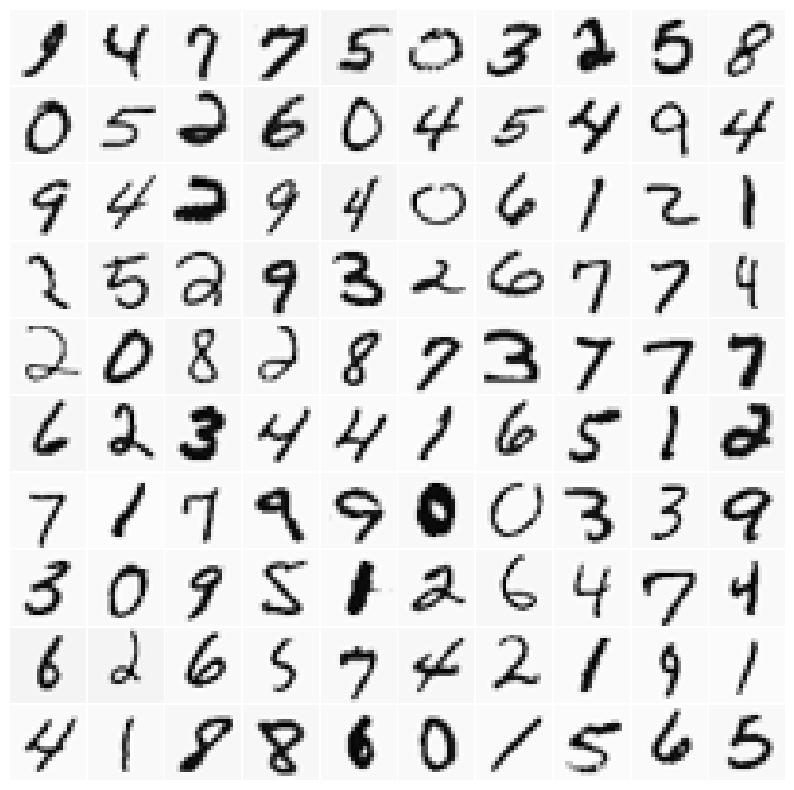

In [14]:
 # 1. Visualizing data
rand_indices = np.random.choice(y.size,100,replace=False)
selection= X[rand_indices,:]
display_data(selection)

In [15]:
#2. Model representation: 
"""
Our Neural Network has 3 layers - Input layer, Hidden layer and Output Layer. 
- Input layer has 20x20 = 400 units, not counting the extra bias unit;

- Hidden layer has 25 units (neurons)

- Output layer has 10 units, which corresponds to No of output classes, where 0 is 10, 1 is 1, .. and so on.

- We have been provided with the set of network parameters from ex4weights.mat.
"""

input_layer_size = 20*20
hidden_layer_size = 25
num_labels = 10

weights = loadmat('../data/ex4weights.mat')

weights.keys() #dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

Theta1, Theta2 = weights['Theta1'], weights['Theta2']
Theta1 # Theta1 is 25x401, which reffer to 25 neurons in hidden layer and 401 predictor in input layer. That is OK
Theta2 #Theta2 is 10x26 which reffer to 10 output classes and 25+1 (bias) neurons in hidden layer 

#In Theta2 we need to move down the first row which reffer to class label 10. 
Theta2 = np.roll(Theta2,1,axis=0) # we are rolling 1st row (row bc axis=0) to the last row [0,1..9]-->[1,2...9,0]
#We do not need to roll Theta1 because it has no connection with output classes
nn_params = np.concatenate([Theta1.ravel(),Theta2.ravel()])
nn_params #10285 rows, which is 25x401 + 10x26 = so one column is added to Theta1 and Theta2 because of biases.

array([-2.25623899e-02, -1.05624163e-08,  2.19414684e-09, ...,
       -2.23093151e-01, -1.40442136e+00, -2.13191530e+00])

In [16]:
def sigmoid(z):
    """
    Compute the sigmoid function of z
    :param z: array 1D vecotr or 2D matrix
    :return: array or matrix of sigmoid func for every element 
    """
    z = np.array(z)
    g = np.zeros(z.shape)
    g = (1/(1+np.exp(-z)))
    return g 

def sigmoidGradient(z):
    g = np.zeros(z.shape)
    g = sigmoid(z)*(1 - sigmoid(z))
    return g 

In [17]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_=0.0):
    
    """
    
    :param nn_params: size of Theta1+Theta2
    :param input_layer_size: No of predictors (without bias)
    :param hidden_layer_size: No of neurons in hidden layer - 25  
    :param num_labels: No of output classes 
    :param X: INPUT DATASET - matrix of shape (m x input_layer_size)
    :param y: TARGET VARIABLE - vector of shape (m,)
    :param lambda_: regularization parameter
    :return: cost function and unrolled vector of partial derivates of the concatenation of Theta1 and Theta2!
    """

    """
    Imamo listu od Theta1+Theta2 parametara i treba da je pretvorimo u matricu gde u prvu matricu treba ubaciti 25x401 elemenata tj. to su vi elementi od 0:25*(20*20+1) elementa upakovani u shape (25,401)
    """
    Theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size,input_layer_size+1)) 

    Theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):],(num_labels,(hidden_layer_size+1)))

    m = y.size # No of observations of training set
    
    #What do we need to calculate:
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    a1 = np.concatenate([np.ones((m,1)),X],axis=1) # na matricu X dodati jednu kolonu jedinica koji su biases ne bismo li dobili a1 layer. 
    a2 = sigmoid(a1.dot(Theta1.T)) # kada pomnozimo transp. Theta1 matricu i matricu a1 i svaki element novog proizvoda ubacimo u sigmoidnu fju, dobijamo a2
    
    a2 = np.concatenate([np.ones((a2.shape[0],1)),a2],axis=1)
    a3 = sigmoid(a2.dot(Theta2.T)) # PREDICTED VALUES!!!
    
    y_matrix = y.reshape(-1)
    y_matrix = np.eye(num_labels)[y_matrix]

    temp1 = Theta1 
    temp2 = Theta2 
    
    #Add regularization term!
    reg_term = (lambda_ / (2 * m)) * (np.sum(np.square(temp1[:, 1:])) + np.sum(np.square(temp2[:, 1:])))

    J = (-1/m) * np.sum((np.log(a3)*y_matrix)+(np.log(1-a3)*(1-y_matrix))) + reg_term 

    #Backpropagation:
    delta_3 = a3-y_matrix # differences between predicted and real values 
    delta_2 = delta_3.dot(Theta2)[:,1:]*sigmoidGradient(a1.dot(Theta1.T)) # sigGrad(z(2))
    
    Delta1 = delta_2.T.dot(a1)
    Delta2 = delta_3.T.dot(a2)
    
    #Adding regularization 
    
    Theta1_grad = (1/m)*Delta1
    Theta2_grad = (1/m)*Delta2
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (lambda_ / m) * Theta1[:, 1:]
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (lambda_ / m) * Theta2[:, 1:]
    
    grad = np.concatenate([Theta1_grad.ravel(),Theta2_grad.ravel()])
    return J, grad 

In [18]:
# checking nnCostFunction where result needs to be 0.287629 
lambda_=0
J,_ = nn_cost_function(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,lambda_)

print(f"For given parameters from ex4weights cost is: {J}")

For given parameters from ex4weights cost is: 0.2876291651613189


In [19]:
# adding regularization:
#J needs to be0.383770
lambda_=1
J,_ = nn_cost_function(nn_params,input_layer_size,hidden_layer_size,num_labels,X,y,lambda_)

print(f"For given parameters from ex4weights cost is: {J}")

For given parameters from ex4weights cost is: 0.38376985909092365


In [20]:
def rand_initialize_weights(L_in, L_out,epsilon_init=0.12):
    """
    Random initialization of weights of a layer in neural network
    
    :param L_in:  No of incoming connections
    :param L_out: No of outgoing connections  
    :param epsilon_init: 
    Range of values which the weight can take from a uniform distribution
    
    :return: 
    W as weights matrix of randomly initialised values in (L_out,1+L_in) shape.
    """
    W = np.zeros((L_out,1+L_in))
    W = np.random.rand(L_out,1+L_in)*2*epsilon_init - epsilon_init
    return W 

In [21]:
"""
Initializing Neural Network Parameters:
"""
initial_Theta1 = rand_initialize_weights(input_layer_size,hidden_layer_size)
initial_Theta2 = rand_initialize_weights(hidden_layer_size,num_labels)
initial_nn_params = np.concatenate([initial_Theta1.ravel(), initial_Theta2.ravel()],axis=0)

In [22]:
initial_nn_params

array([-0.05479992, -0.0407172 ,  0.04408783, ...,  0.07479113,
       -0.09556514, -0.11193655])

In [23]:
def debug_initialize_weights(fan_out, fan_in):
    """
    Initialize the weights of a layer with fan_in incoming connections and fan_out outgoings
    connections using a fixed strategy. This will help you later in debugging.

    Note that W should be set a matrix of size (1+fan_in, fan_out) as the first row of W handles
    the "bias" terms.

    Parameters
    ----------
    fan_out : int
        The number of outgoing connections.

    fan_in : int
        The number of incoming connections.

    Returns
    -------
    W : array_like (1+fan_in, fan_out)
        The initialized weights array given the dimensions.
    """
    # Initialize W using "sin". This ensures that W is always of the same values and will be
    # useful for debugging
    W = np.sin(np.arange(1, 1 + (1+fan_in)*fan_out))/10.0
    W = W.reshape(fan_out, 1+fan_in, order='F')
    return W

In [24]:
def compute_numerical_gradient(J, theta, e=1e-4):
    """
    Computes the gradient using "finite differences" and gives us a numerical estimate of the
    gradient.

    Parameters
    ----------
    J : func
        The cost function which will be used to estimate its numerical gradient.

    theta : array_like
        The one dimensional unrolled network parameters. The numerical gradient is computed at
         those given parameters.

    e : float (optional)
        The value to use for epsilon for computing the finite difference.

    Notes
    -----
    The following code implements numerical gradient checking, and
    returns the numerical gradient. It sets `numgrad[i]` to (a numerical
    approximation of) the partial derivative of J with respect to the
    i-th input argument, evaluated at theta. (i.e., `numgrad[i]` should
    be the (approximately) the partial derivative of J with respect
    to theta[i].)
    """
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1, _ = J(theta - perturb[:, i])
        loss2, _ = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad

In [25]:
def check_nn_gradients(nnCostFunction, lambda_=0):
    """
    Creates a small neural network to check the backpropagation gradients. It will output the
    analytical gradients produced by your backprop code and the numerical gradients
    (computed using computeNumericalGradient). These two gradient computations should result in
    very similar values.

    Parameters
    ----------
    nnCostFunction : func
        A reference to the cost function implemented by the student.

    lambda_ : float (optional)
        The regularization parameter value.
    """
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # We generate some 'random' test data
    Theta1 = debug_initialize_weights(hidden_layer_size, input_layer_size)
    Theta2 = debug_initialize_weights(num_labels, hidden_layer_size)

    # Reusing debugInitializeWeights to generate X
    X = debug_initialize_weights(m, input_layer_size - 1)
    y = np.arange(1, 1+m) % num_labels
    # print(y)
    # Unroll parameters
    nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])

    # short hand for cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size,
                                        num_labels, X, y, lambda_)
    cost, grad = costFunc(nn_params)
    numgrad = compute_numerical_gradient(costFunc, nn_params)

    # Visually examine the two gradient computations.The two columns you get should be very similar.
    print(np.stack([numgrad, grad], axis=1))
    print('The above two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)\n')

    # Evaluate the norm of the difference between two the solutions. If you have a correct
    # implementation, and assuming you used e = 0.0001 in computeNumericalGradient, then diff
    # should be less than 1e-9.
    diff = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)

    print('If your backpropagation implementation is correct, then \n'
          'the relative difference will be small (less than 1e-9). \n'
          'Relative Difference: %g' % diff)

In [26]:
check_nn_gradients(nn_cost_function)

[[-9.27825235e-03 -9.27825236e-03]
 [-3.04978709e-06 -3.04978914e-06]
 [-1.75060084e-04 -1.75060082e-04]
 [-9.62660640e-05 -9.62660620e-05]
 [ 8.89911959e-03  8.89911960e-03]
 [ 1.42869450e-05  1.42869443e-05]
 [ 2.33146358e-04  2.33146357e-04]
 [ 1.17982666e-04  1.17982666e-04]
 [-8.36010761e-03 -8.36010762e-03]
 [-2.59383093e-05 -2.59383100e-05]
 [-2.87468729e-04 -2.87468729e-04]
 [-1.37149709e-04 -1.37149706e-04]
 [ 7.62813550e-03  7.62813551e-03]
 [ 3.69883257e-05  3.69883234e-05]
 [ 3.35320351e-04  3.35320347e-04]
 [ 1.53247082e-04  1.53247082e-04]
 [-6.74798369e-03 -6.74798370e-03]
 [-4.68759742e-05 -4.68759769e-05]
 [-3.76215583e-04 -3.76215587e-04]
 [-1.66560294e-04 -1.66560294e-04]
 [ 3.14544970e-01  3.14544970e-01]
 [ 1.64090819e-01  1.64090819e-01]
 [ 1.64567932e-01  1.64567932e-01]
 [ 1.58339334e-01  1.58339334e-01]
 [ 1.51127527e-01  1.51127527e-01]
 [ 1.49568335e-01  1.49568335e-01]
 [ 1.11056588e-01  1.11056588e-01]
 [ 5.75736494e-02  5.75736493e-02]
 [ 5.77867378e-02  5

In [27]:
options = {'maxiter':100}
lambda_=1
cost_function = lambda p: nn_cost_function(p,input_layer_size,hidden_layer_size,num_labels,X,y,lambda_)
res = optimize.minimize(cost_function,initial_nn_params,jac=True,method='CG',options=options)
nn_params = res.x # my params
Theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)],(hidden_layer_size,(input_layer_size+1)))
Theta2 = np.reshape(nn_params[(hidden_layer_size*(input_layer_size+1)):],(num_labels,(hidden_layer_size+1)))

In [28]:
res 

 message: Maximum number of iterations has been exceeded.
 success: False
  status: 1
     fun: 0.36062241789250743
       x: [-2.096e-01 -1.915e-02 ... -3.786e+00  3.768e-01]
     nit: 100
     jac: [-4.759e-04 -3.830e-06 ...  2.474e-04  1.503e-04]
    nfev: 223
    njev: 223

In [29]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    Outputs the predicted label of X given the trained weights of a neural
    network(Theta1, Theta2)
    """
    # Useful values
    m = X.shape[0]
    num_labels = Theta2.shape[0]

    # You need to return the following variables correctly
    p = np.zeros(m)
    h1 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), X], axis=1), Theta1.T))
    h2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h1], axis=1), Theta2.T))
    p = np.argmax(h2, axis=1)
    return p

In [30]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: %f' % (np.mean(pred == y) * 100))

Training Set Accuracy: 98.120000


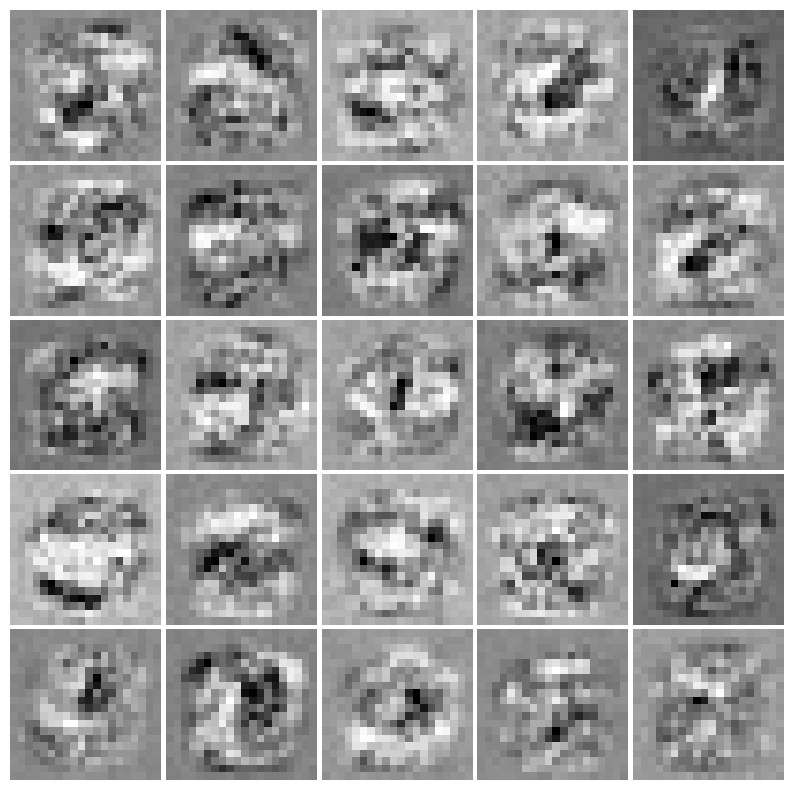

In [32]:
#Visualizing hidden layer: 
display_data(Theta1[:,1:])